<a href="https://colab.research.google.com/github/mahmud-nobe/Cluster-Membership/blob/master/M67_GMM%2BRF_model_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Necessary Packages and download the csv files

#### Importing packages

In [ ]:
# import packages
import pandas as pd
#import pandas_profiling as pd_prof
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# for downloading file
#from google.colab import files

## Use random forest to create and evaluate new model
from sklearn.ensemble import RandomForestClassifier

In [ ]:
!pip install astroquery

     |████████████████████████████████| 4.4MB 7.2MB/s 
     |████████████████████████████████| 808kB 36.2MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 3.2MB 43.8MB/s 
  Created wheel for mimeparse: filename=mimeparse-0.1.3-cp37-none-any.whl size=3864 sha256=ded8f05c7269a5701486aa94e609d88c7980441ee325ccca9ab3e94a7de1d5b0
  Stored in directory: /root/.cache/pip/wheels/54/ca/c7/3db47cc5c748286db22a7fab43ccf985903d2b9ca119de16ab
Successfully built mimeparse


In [ ]:
# import astroquery
import astropy.units as u
import astropy.coordinates as coord
from astroquery.gaia import Gaia
from astroquery.vizier import Vizier


#### Finding GAIA Data

In [ ]:
## making a GAIA cone_search of 30m radius around M67 center

coordinate = coord.SkyCoord.from_name('M67')
print(coordinate)
radius = u.Quantity(1, u.deg)
Gaia.ROW_LIMIT = -1
# table = "gaiaedr3.gaia_source"
table = "gaiadr2.gaia_source"
j = Gaia.cone_search_async(coordinate, radius, table_name=table)
r = j.get_results()
print(type(r))

<SkyCoord (ICRS): (ra, dec) in deg
    (132.825, 11.8)>
INFO: Query finished. [astroquery.utils.tap.core]
<class 'astropy.table.table.Table'>


In [ ]:
#r = pd.read_csv('M_67_GAIA_DR2_1deg.csv')

In [ ]:
## save the ASCII table as a panadas dataframe
all_stars = r.to_pandas()
all_stars


solution_id  ...      dist
0      1635721458409799680  ...  0.004991
1      1635721458409799680  ...  0.005831
2      1635721458409799680  ...  0.007206
3      1635721458409799680  ...  0.008407
4      1635721458409799680  ...  0.008957
...                    ...  ...       ...
19444  1635721458409799680  ...  0.999886
19445  1635721458409799680  ...  0.999947
19446  1635721458409799680  ...  0.999947
19447  1635721458409799680  ...  0.999989
19448  1635721458409799680  ...  0.999996

[19449 rows x 96 columns]

In [ ]:
#all_stars.to_csv('M_67_GAIA_DR2_1deg.csv')

#files.download('M_67_GAIA_DR2_1deg.csv')

##### Applying Filter:

In [ ]:
#all_stars['pmra_over_error'] = abs(all_stars['pmra']/all_stars['pmra_error'])
#all_stars['pmdec_over_error'] = abs(all_stars['pmdec']/all_stars['pmdec_error'])

In [ ]:
#all_stars_filtered = all_stars[all_stars['parallax_over_error'] > 3]

In [ ]:
#all_stars_filtered = all_stars_filtered[(all_stars_filtered.pmra_error < 0.3) & (all_stars_filtered.pmdec_error < 0.3)]

In [ ]:
#all_stars_filtered.shape

##### Visualizing GAIA data

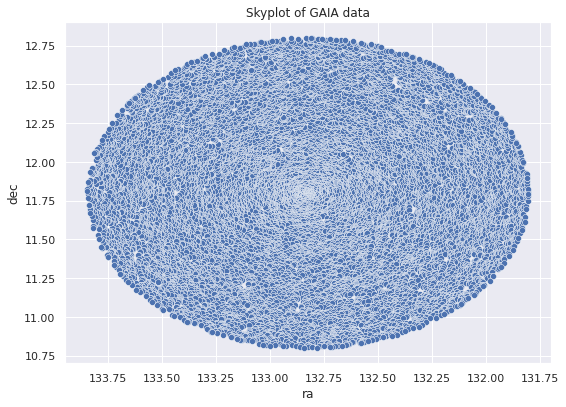

In [ ]:
## plotting the skyplot 

sns.set(rc={'figure.figsize':(8.7,6.27)})

skyplot = sns.scatterplot(x='ra', y='dec', data = all_stars)
skyplot.invert_xaxis()
plt.title('Skyplot of GAIA data')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-5.0, 10.0)

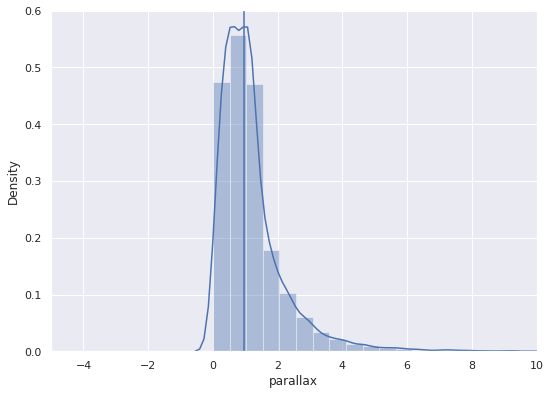

In [ ]:
sns.distplot(all_stars[all_stars['parallax'] >= 0].parallax)
plt.axvline(all_stars[all_stars['parallax'] >= 0].parallax.median())
plt.xlim(-5,10)


In [ ]:
all_stars['distance_pc'] = 1/(all_stars.parallax*0.001)

In [ ]:
print(len(all_stars))

all_stars = all_stars[all_stars['parallax'] >= 0]
print(len(all_stars))

all_stars = all_stars[all_stars.loc[:, 'pmra'].notnull()]
print(len(all_stars))

all_stars = all_stars[all_stars.loc[:, 'bp_rp'].notnull()]
print(len(all_stars))

all_stars = all_stars[(abs(all_stars['pmra']) < 20) & (abs(all_stars['pmdec']) < 20)]
print(len(all_stars))

all_stars = all_stars[all_stars['dist'] < (60/60)]
print(len(all_stars))

all_stars = all_stars[((all_stars['distance_pc']) < 1600) & ((all_stars['distance_pc']) > 500)]
print(len(all_stars))


19449
14216
14216
14115
12981
12981
7311


(array([ 755.,  787.,  986., 1519.,  792.,  653.,  536.,  463.,  451.,
         369.]),
 array([ 500.41007029,  610.36690473,  720.32373917,  830.28057361,
         940.23740805, 1050.19424249, 1160.15107693, 1270.10791137,
        1380.06474581, 1490.02158025, 1599.97841469]),
 <a list of 10 Patch objects>)

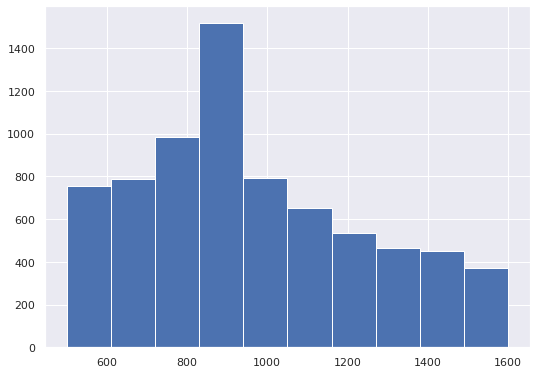

In [ ]:
plt.hist(all_stars.distance_pc)

## Building GMM Model

#### Trial 1:

In [ ]:
feature_columns = ['parallax', 'pmra', 
                   'pmdec']

features = all_stars.loc[:,feature_columns].dropna()

features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7311 entries, 0 to 19448
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   parallax  7311 non-null   float64
 1   pmra      7311 non-null   float64
 2   pmdec     7311 non-null   float64
dtypes: float64(3)
memory usage: 228.5 KB


In [ ]:
features.columns

Index(['parallax', 'pmra', 'pmdec'], dtype='object')

In [ ]:
scaled_features = pd.DataFrame({})
for column in features.columns:
    scaled_features[column] = (features[column] - np.median(features[column]))/np.std(features[column])
scaled_features

parallax      pmra     pmdec
0      0.037778 -0.962178 -0.040652
1      0.087166 -1.028697 -0.059392
2      2.374588 -0.939790  0.060745
3      0.460795 -0.967353 -0.025028
4      0.652816 -0.958752 -0.003587
...         ...       ...       ...
19421 -0.597965  0.855980 -0.546181
19422  1.686106  0.020422  0.080667
19428 -0.637413  0.758210 -0.077888
19434 -0.706022 -0.314518 -0.521016
19448 -0.975405  0.232300  0.462954

[7311 rows x 3 columns]

In [ ]:
#from sklearn.preprocessing import MinMaxScaler


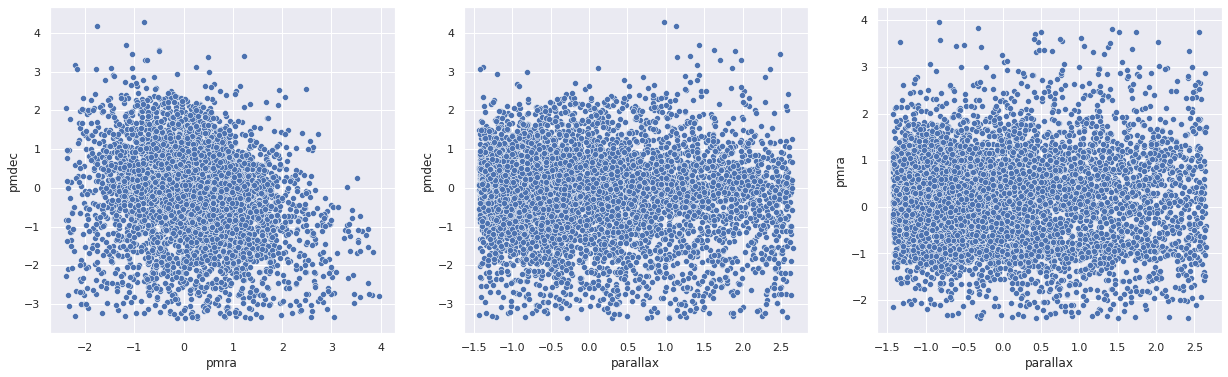

In [ ]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21,6))
#fig.figure(figsize = (35,6))
#fig.suptitle('Horizontally stacked subplots')
#ax1.plot(x, y)
#ax2.plot(x, -y)

sns.scatterplot(x='pmra', y='pmdec', data=scaled_features, ax=ax1)
#plt.show()

#plt.subplot(132)
sns.scatterplot(x='parallax', y='pmdec', data=scaled_features, ax=ax2)
#plt.show()

#plt.subplot(133)
sns.scatterplot(x='parallax', y='pmra', data=scaled_features, ax=ax3)
plt.show()

In [ ]:

#scaler = MinMaxScaler()
#scaler.fit(features)

In [ ]:
#scaler.transform(features)

In [ ]:
#scaled_feature = scaler.transform(features)

In [ ]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2)
gmm.fit(scaled_features)



GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [ ]:
len(all_stars), len(scaled_features)

(7311, 7311)

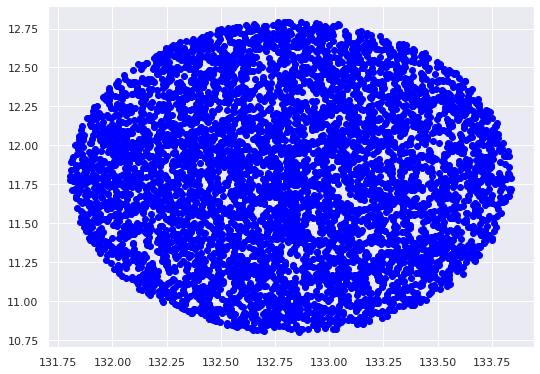

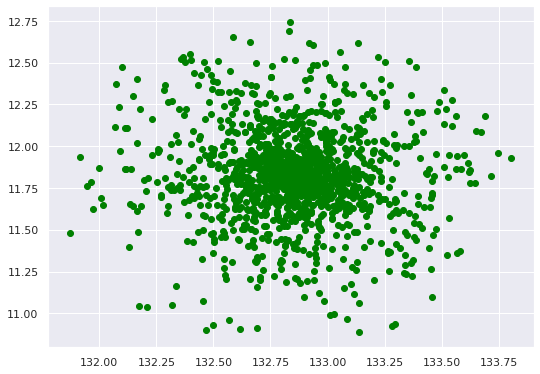

In [ ]:
#predictions from gmm
labels = gmm.predict(scaled_features)

probs = gmm.predict_proba(scaled_features)

all_stars['PMemb'] = probs[:, 1]
all_stars['cluster'] = labels

color=['blue','green']
for k in range(0,2):
    data = all_stars[all_stars["cluster"]==k]
    plt.scatter(data["ra"],data["dec"],c=color[k])
    plt.show()

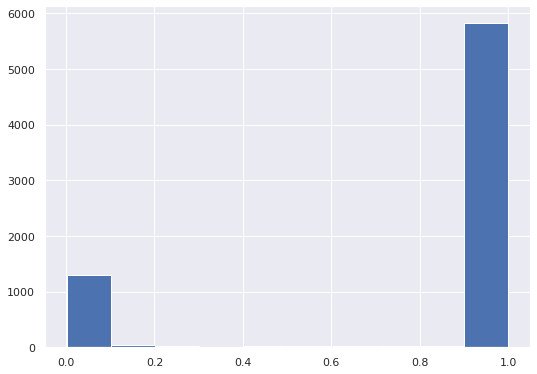

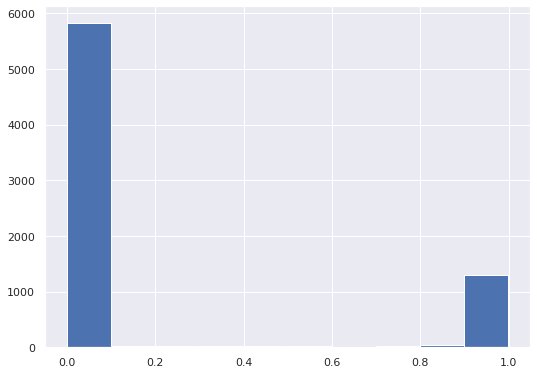

In [ ]:
plt.hist(probs[:, 0])
#plt.ylim(0, 3500)
plt.show()
plt.hist(probs[:, 1])
plt.show()

In [ ]:
probs.shape

(3841, 2)

In [ ]:
member = all_stars[all_stars['PMemb'] >= 0.95]
non_member = all_stars[all_stars['PMemb'] == 0]

In [ ]:
len(member), len(non_member)

(1190, 1187)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


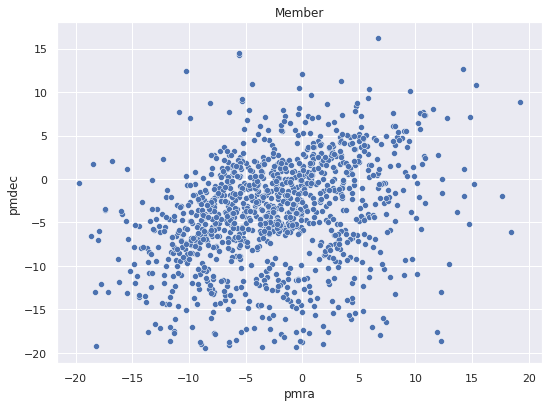

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


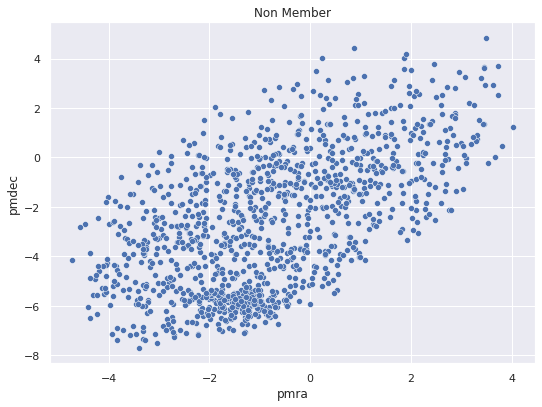

In [ ]:
#member = features[features['cluster'] == 1]
#non_member = features[features['cluster'] == 0]
sns.scatterplot('pmra', 'pmdec', data = member)
plt.title('Member')
plt.show()

sns.scatterplot('pmra', 'pmdec', data = non_member)
plt.title('Non Member')
plt.show()

In [ ]:
all_stars.cluster.value_counts()

1    2201
0    1640
Name: cluster, dtype: int64

In [ ]:
len(member), len(non_member)

(4279, 2612)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


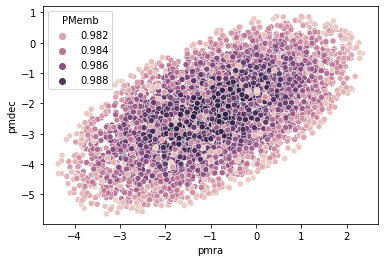

In [ ]:
sns.scatterplot('pmra', 'pmdec', hue = 'PMemb', data = all_stars[all_stars.PMemb > 0.98 ])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


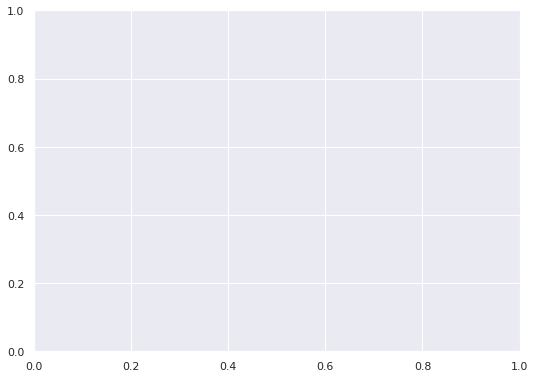

In [ ]:
sns.scatterplot('parallax', 'PMemb', data = all_stars[all_stars.PMemb > 0.98])
plt.show()

#### Visualizing Training Data


In [ ]:
training_data = pd.concat([member.assign(member=1), non_member.assign(member=0)])
training_data.describe()

solution_id     source_id  ...      cluster       member
count  3.510000e+03  3.510000e+03  ...  3510.000000  3510.000000
mean   1.635721e+18  6.035655e+17  ...     0.350142     0.350142
std    0.000000e+00  2.941908e+15  ...     0.477082     0.477082
min    1.635721e+18  5.986147e+17  ...     0.000000     0.000000
25%    1.635721e+18  5.989764e+17  ...     0.000000     0.000000
50%    1.635721e+18  6.049084e+17  ...     0.000000     0.000000
75%    1.635721e+18  6.049747e+17  ...     1.000000     1.000000
max    1.635721e+18  6.081324e+17  ...     1.000000     1.000000

[8 rows x 95 columns]

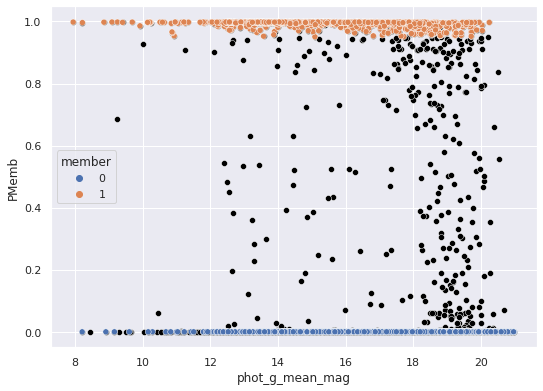

In [ ]:
sns.scatterplot(x='phot_g_mean_mag', y = 'PMemb', data = all_stars, color = 'black')
sns.scatterplot(x='phot_g_mean_mag', y = 'PMemb', hue = 'member', data = training_data)

(array([5829.,   25.,   22.,   19.,   18.,   20.,   12.,   28.,   43.,
        1295.]),
 array([0.        , 0.09984119, 0.19968239, 0.29952358, 0.39936478,
        0.49920597, 0.59904717, 0.69888836, 0.79872956, 0.89857075,
        0.99841195]),
 <a list of 10 Patch objects>)

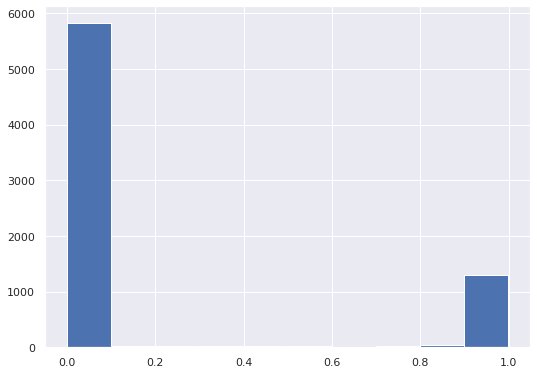

In [ ]:
plt.hist(all_stars.PMemb)

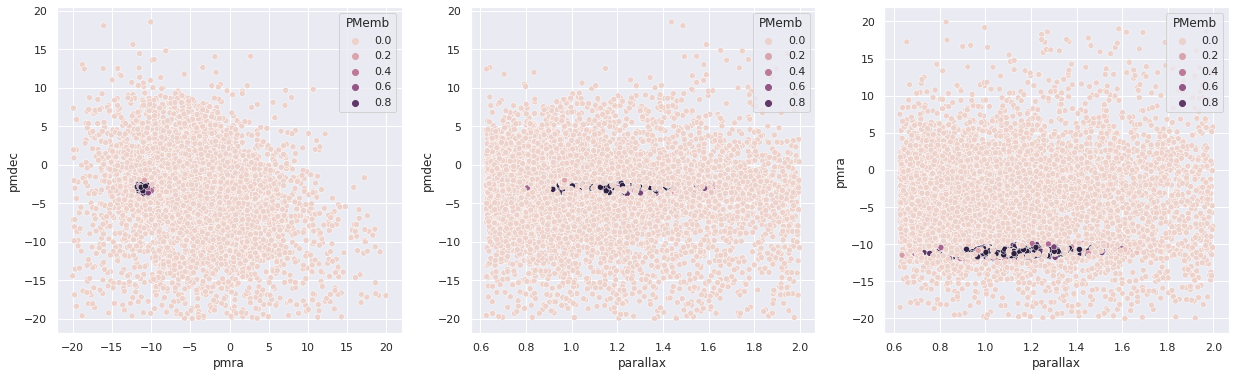

In [ ]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21,6))
#fig.figure(figsize = (35,6))
#fig.suptitle('Horizontally stacked subplots')
#ax1.plot(x, y)
#ax2.plot(x, -y)

sns.scatterplot(x='pmra', y='pmdec', data = all_stars, hue = 'PMemb', ax=ax1)
#plt.show()

#plt.subplot(132)
sns.scatterplot(x='parallax', y='pmdec', data = all_stars, hue = 'PMemb', ax=ax2)
#plt.show()

#plt.subplot(133)
sns.scatterplot(x='parallax', y='pmra', data = all_stars, hue = 'PMemb', ax=ax3)
plt.show()

#sns.scatterplot(x='pmra', y ='pmdec', data = all_stars, hue = 'PMemb')

-10.950495139793384 -2.9619947716953106


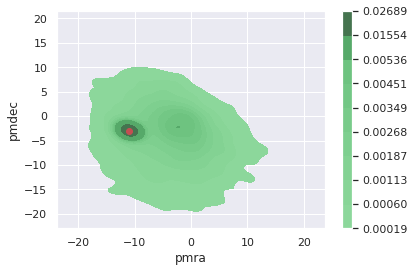

In [ ]:
%matplotlib inline
# neural network --> three side


#cbar_kws = { 'ticks' : np.linspace(0.01, 0.12, 8),
#               'label': 'Probability Density [(mas/year)$^{-2}$]'}

kde = sns.kdeplot(x='pmra', y='pmdec', data =all_stars, shade=True, color = 'g',
                      bw_method = 0.20, cbar=True)

for path in kde.collections[-1].get_paths():
    x, y = path.vertices.mean(axis=0)
    kde.plot(x, y, "ro")
    print(x, y)
    center = (x,y)
plt.show()

1.1313717190787578 -2.9647642391944053


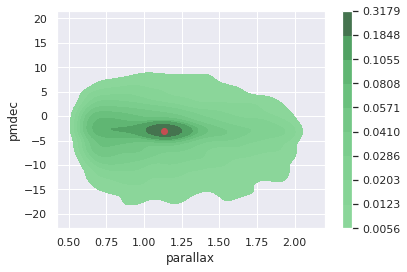

In [ ]:
kde = sns.kdeplot(x='parallax', y='pmdec', data =all_stars, shade=True, color = 'g',
                      bw_method = 0.20, cbar=True)

for path in kde.collections[-1].get_paths():
    x, y = path.vertices.mean(axis=0)
    kde.plot(x, y, "ro")
    print(x, y)
    center = (x,y)
plt.show()

1.141714750952221 -10.987522588885282


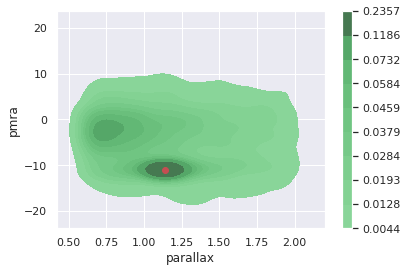

In [ ]:
kde = sns.kdeplot(x='parallax', y='pmra', data =all_stars, shade=True, color = 'g',
                      bw_method = 0.20, cbar=True)

for path in kde.collections[-1].get_paths():
    x, y = path.vertices.mean(axis=0)
    kde.plot(x, y, "ro")
    print(x, y)
    center = (x,y)
plt.show()

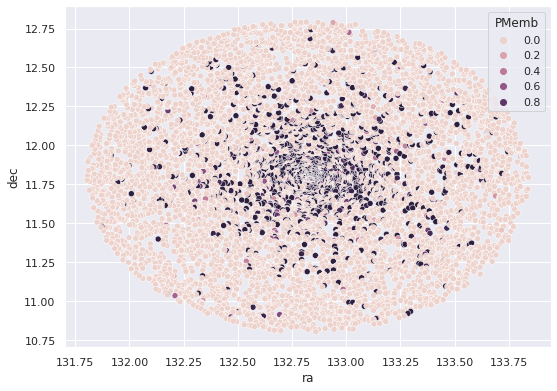

In [ ]:
sns.scatterplot(x='ra', y ='dec', data = all_stars, hue = 'PMemb')

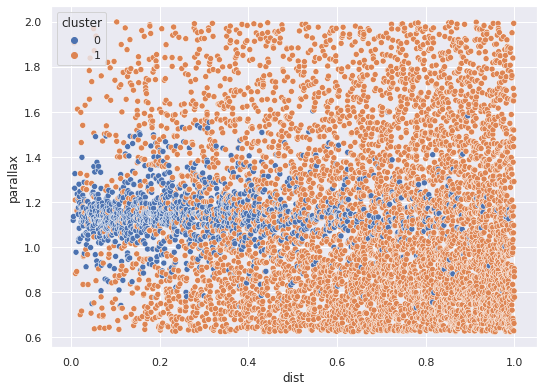

In [ ]:
sns.scatterplot(x='dist', y ='parallax', data = all_stars, hue = 'cluster')

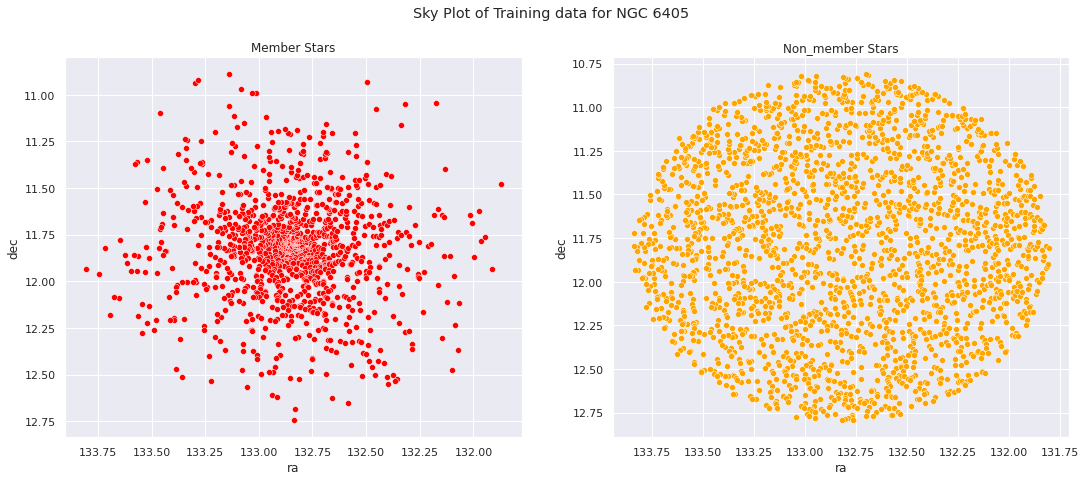

In [ ]:


fig, axes = plt.subplots(1, 2, figsize=(18,7))
fig.suptitle('Sky Plot of Training data for NGC 6405')

skyplot = sns.scatterplot(x = 'ra', y='dec', palette='YlOrRd', color = 'red', data = member,
                         ax = axes[0])
skyplot.invert_xaxis()
axes[0].set_title('Member Stars')
axes[0].invert_yaxis()

#plt.show()
skyplot = sns.scatterplot(x = 'ra', y='dec', palette='YlOrRd', color = 'orange', data = non_member,
                         ax = axes[1])
skyplot.invert_xaxis()
axes[1].set_title('Non_member Stars')
axes[1].invert_yaxis()

plt.show()

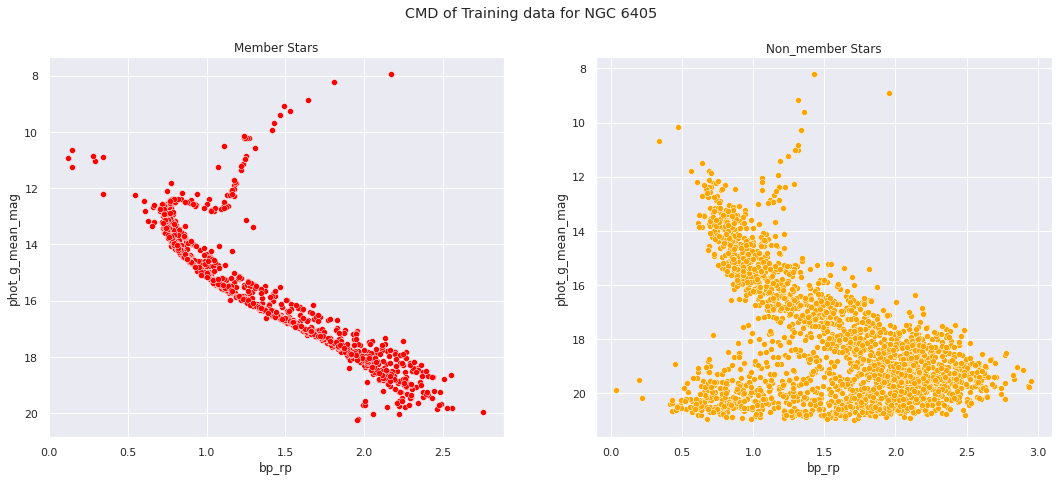

In [ ]:
# CMD marked with the membership probabilities of the stars 
# (PMemb >= 0.5 stars are the probable stars)
#cmd = sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag', palette='YlOrRd', hue = 'PMemb', data = training_data)
#cmd.invert_yaxis()
#plt.title('')
#plt.show()

# proper motion plot marked with the membership probabilities of the stars 

fig, axes = plt.subplots(1, 2, figsize=(18,7))
fig.suptitle('CMD of Training data for NGC 6405 ')

sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag', palette='YlOrRd', color = 'red',
                data = member, ax = axes[0])
axes[0].set_title('Member Stars')
axes[0].invert_yaxis()

#plt.show()
sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag', palette='YlOrRd', color = 'orange',
                data = non_member, ax = axes[1])
axes[1].set_title('Non_member Stars')
axes[1].invert_yaxis()

plt.show()


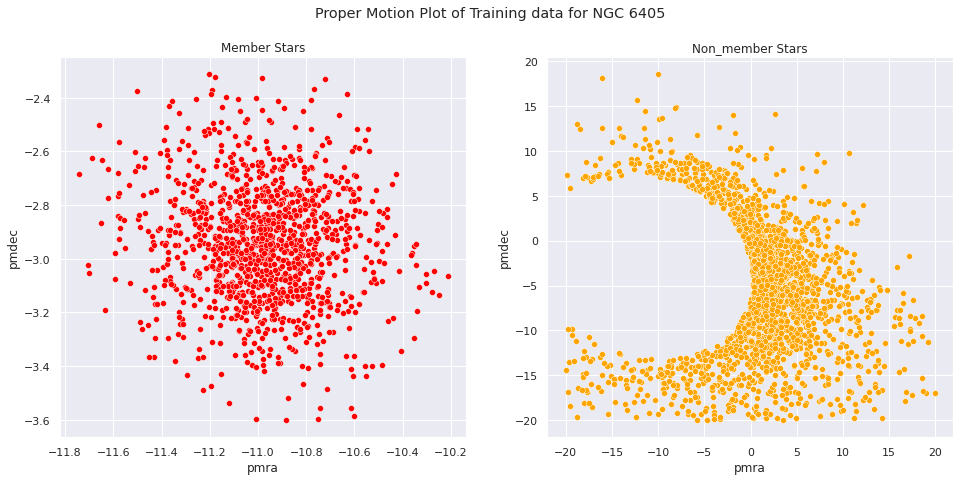

In [ ]:
# proper motion plot marked with the membership probabilities of the stars 

fig, axes = plt.subplots(1, 2, figsize=(16,7))
fig.suptitle('Proper Motion Plot of Training data for NGC 6405 ')

sns.scatterplot(x = 'pmra', y='pmdec', palette='YlOrRd', color = 'red',
                data = member, ax = axes[0])
axes[0].set_title('Member Stars')
#plt.show()
sns.scatterplot(x = 'pmra', y='pmdec', palette='YlOrRd', color = 'orange',
                data = non_member, ax = axes[1])
axes[1].set_title('Non_member Stars')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


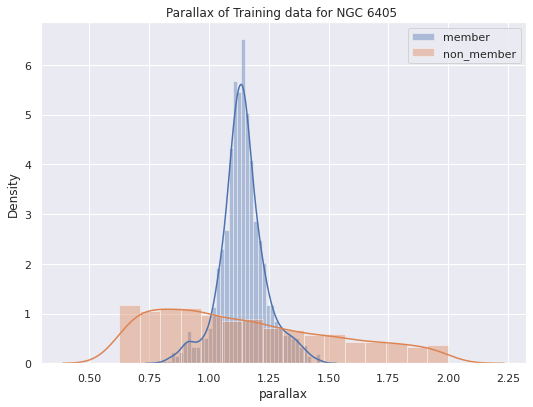

In [ ]:
sns.distplot(member.parallax, label='member')
sns.distplot(non_member.parallax, label = 'non_member')
#plt.xlim(-10,10)
plt.title('Parallax of Training data for NGC 6405 ')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


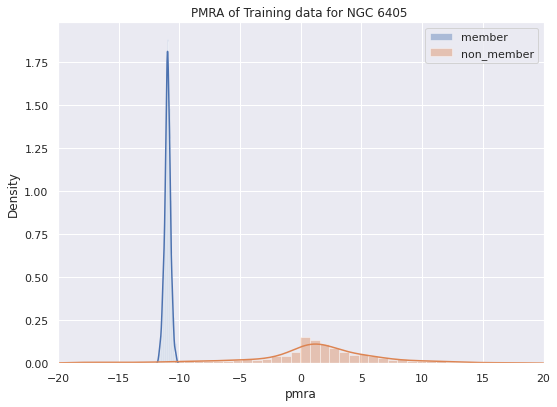

In [ ]:
sns.distplot(member.pmra, label='member')
sns.distplot(non_member.pmra, label = 'non_member')
plt.xlim(-20,20)
plt.title('PMRA of Training data for NGC 6405 ')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


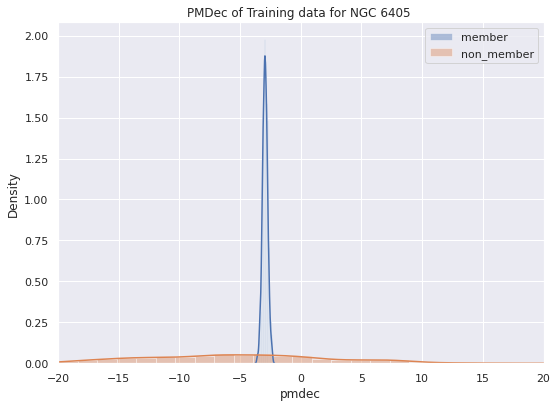

In [ ]:
sns.distplot(member.pmdec, label='member')
sns.distplot(non_member.pmdec, label = 'non_member')
plt.xlim(-20,20)
plt.title('PMDec of Training data for NGC 6405 ')
plt.legend()
plt.show()

In [ ]:
#sns.scatterplot(x='bp_rp', y = 'PMemb', data = all_stars, color = 'black')


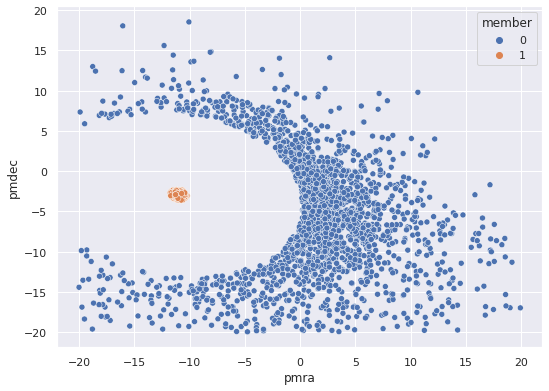

In [ ]:
sns.scatterplot(data=training_data, x='pmra', y='pmdec', hue = 'member')

## RF Training Start From Here

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


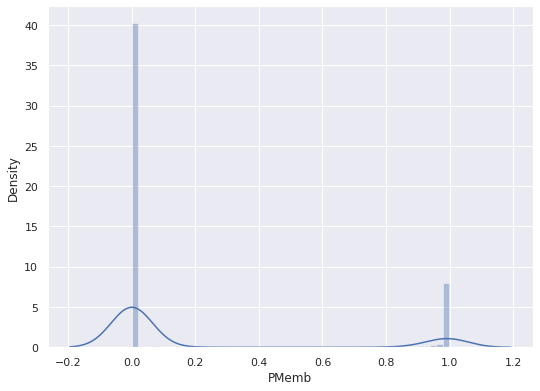

In [ ]:
# histogram of PMemb in the training data
sns.distplot(training_data['PMemb'])
plt.show()

In [ ]:
training_data = pd.concat([member.assign(member=1), non_member.assign(member=0)])
training_data.describe()

solution_id     source_id  ...      cluster       member
count  3.496000e+03  3.496000e+03  ...  3496.000000  3496.000000
mean   1.635721e+18  6.035680e+17  ...     0.647883     0.352117
std    0.000000e+00  2.940971e+15  ...     0.477698     0.477698
min    1.635721e+18  5.986147e+17  ...     0.000000     0.000000
25%    1.635721e+18  5.989767e+17  ...     0.000000     0.000000
50%    1.635721e+18  6.049084e+17  ...     1.000000     0.000000
75%    1.635721e+18  6.049749e+17  ...     1.000000     1.000000
max    1.635721e+18  6.081324e+17  ...     1.000000     1.000000

[8 rows x 95 columns]

In [ ]:
# Examining the descriptive statistics of each column
training_data.describe()

solution_id     source_id  ...      cluster       member
count  3.496000e+03  3.496000e+03  ...  3496.000000  3496.000000
mean   1.635721e+18  6.035680e+17  ...     0.647883     0.352117
std    0.000000e+00  2.940971e+15  ...     0.477698     0.477698
min    1.635721e+18  5.986147e+17  ...     0.000000     0.000000
25%    1.635721e+18  5.989767e+17  ...     0.000000     0.000000
50%    1.635721e+18  6.049084e+17  ...     1.000000     0.000000
75%    1.635721e+18  6.049749e+17  ...     1.000000     1.000000
max    1.635721e+18  6.081324e+17  ...     1.000000     1.000000

[8 rows x 95 columns]

In [ ]:
# Choosing the features

feature_columns = ['parallax',
                   'pmra', 'pmdec']

features = training_data.loc[:,feature_columns]
targets = training_data['member']

In [ ]:
# Dropping the NULL values from the using training set
# adding features and targets in a training set
training_set = pd.concat((features, targets), axis=1)

# dropping NA
training_set = training_set.dropna()

# finding where dtype is float64
float64_data = np.where(training_set.dtypes == 'float64')[0] 

# change the data type to float32 from float64
training_set.iloc[:, float64_data] = training_set.iloc[:, float64_data].astype('float32')


# set features, targets again
features, targets = training_set.iloc[:,:-1], training_set.iloc[:,-1]

features.describe()

parallax         pmra        pmdec
count  3496.000000  3496.000000  3496.000000
mean      1.151058    -3.259339    -4.449317
std       0.302792     7.524096     6.030166
min       0.625557   -19.999044   -19.966204
25%       0.956051   -10.913007    -7.413913
50%       1.128148    -1.414218    -3.071736
75%       1.279475     2.266405    -2.592435
max       1.997453    19.932800    18.545561

In [ ]:
targets.value_counts()

0    2265
1    1231
Name: member, dtype: int64

In [ ]:
from mpl_toolkits.mplot3d import Axes3D


ax = plt.figure().gca(projection='3d')

ax.scatter(member.pmra, member.pmdec, member.parallax)
ax.set_xlabel('pmra')
ax.set_ylabel('pmdec')
ax.set_zlabel('parallax')
plt.title('member stars in the 3D space')
plt.show()


In [ ]:
ax = plt.figure().gca(projection='3d')

ax.scatter(non_member.pmra, non_member.pmdec, non_member.parallax)
ax.set_xlabel('pmra')
ax.set_ylabel('pmdec')
ax.set_zlabel('parallax')
plt.title('non-member stars in the 3D space')
plt.show()


#### Check Feature Importance using Random Forest

In [ ]:
# Use Random Forest on whole dataset using 100 different trees 
rfc = RandomForestClassifier(n_estimators = 100, oob_score = True)
rfc.fit(features, targets)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# checking the feature importance, 
# ( this is higher for a variable if the model efficiency become lower as we remove that variable)
feature_imp = pd.Series(rfc.feature_importances_, index=features.columns).sort_values(ascending = False)
feature_imp

pmra        0.623874
pmdec       0.292316
parallax    0.083810
dtype: float64

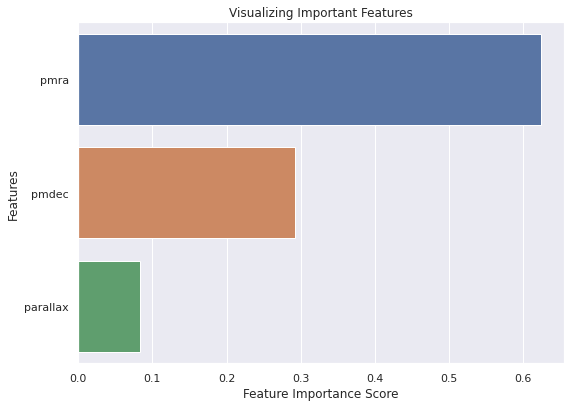

In [ ]:
# plotting as a barplot

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Model Selection and Accuracy Estimate using Test Data

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, classification_report

In [ ]:
from sklearn.model_selection import train_test_split
# splitting our dataset using 0.3 test ratio (30% test data, 70% train data)
train_features, test_features, train_targets, test_targets = train_test_split(features, 
                                                                                targets, 
                                                                                test_size = 0.3, 
                                                                                random_state=258)

In [ ]:
def evaluate_model(model):
    test_predict = model.predict(test_features)
    train_predict = model.predict(train_features)

    print('Model Accuracy:')
    print("Precision on training data: %.3f" % precision_score(train_targets, train_predict))
    print("Precision on testing data: %.3f" % precision_score(test_targets, test_predict))
    print('Accuracy on test data: %.3f' % accuracy_score(test_targets, test_predict))


    sns.heatmap(confusion_matrix(test_targets, test_predict), cmap= 'Greens', annot = True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    print("Classification Report: \n", classification_report(test_targets, test_predict))

#### Random Forest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
# Maximum number of levels
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
ccp_alpha = [2**i for i in range(-10,0)]+[0]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'ccp_alpha': ccp_alpha}

random_grid

{'bootstrap': [True, False],
 'ccp_alpha': [0.0009765625,
  0.001953125,
  0.00390625,
  0.0078125,
  0.015625,
  0.03125,
  0.0625,
  0.125,
  0.25,
  0.5,
  0],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}

In [ ]:
rfc = RandomForestClassifier(random_state = 42,
                                    oob_score = True)

rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, 
                               n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1,
                               scoring = 'precision')

In [ ]:
rfc_random.fit(train_features, train_targets)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.6min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rfc_random.best_params_


{'bootstrap': True,
 'ccp_alpha': 0,
 'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

Model Accuracy:
Precision on training data: 1.000
Precision on testing data: 1.000
Accuracy on test data: 1.000


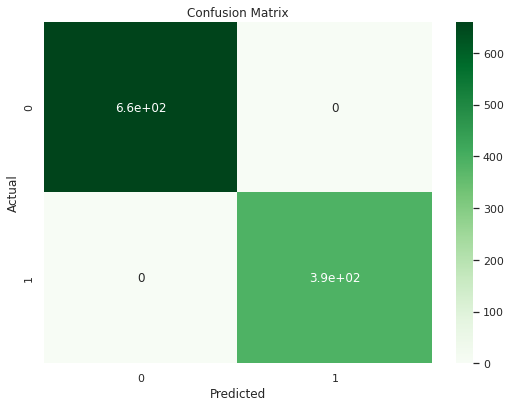

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       659
           1       1.00      1.00      1.00       390

    accuracy                           1.00      1049
   macro avg       1.00      1.00      1.00      1049
weighted avg       1.00      1.00      1.00      1049



In [ ]:
base_model = RandomForestClassifier(n_estimators = 100, random_state = 42,
                                    oob_score = True)
base_model.fit(train_features, train_targets)

evaluate_model(base_model)


Model Accuracy:
Precision on training data: 1.000
Precision on testing data: 1.000
Accuracy on test data: 1.000


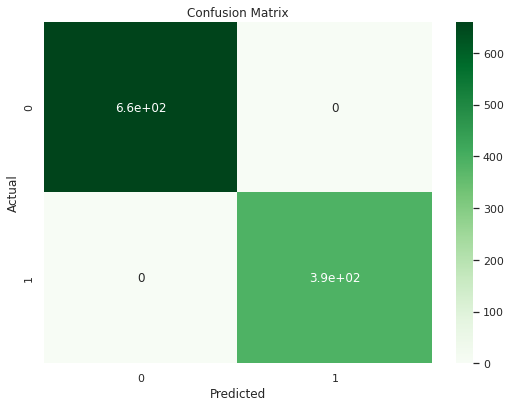

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       659
           1       1.00      1.00      1.00       390

    accuracy                           1.00      1049
   macro avg       1.00      1.00      1.00      1049
weighted avg       1.00      1.00      1.00      1049



In [ ]:
best_random = rfc_random.best_estimator_

evaluate_model(best_random)


### Prediction for the new stars

In [ ]:
# descriptive stats
# chosing only GAIA stars close to 2.5 degree radius of the center

GAIA_target_stars = r.to_pandas()

GAIA_target_stars = GAIA_target_stars[GAIA_target_stars['parallax'] >= 0]

GAIA_target_stars = GAIA_target_stars[GAIA_target_stars.loc[:, 'bp_rp'].notnull()]

GAIA_target_stars = GAIA_target_stars[(abs(GAIA_target_stars['pmra']) < 20) & (abs(GAIA_target_stars['pmdec']) < 20)]

GAIA_target_stars.describe()

solution_id     source_id  ...  lum_percentile_upper          dist
count  7.111700e+04  7.111700e+04  ...          14344.000000  71117.000000
mean   1.635721e+18  6.030829e+17  ...              4.916773      1.629027
std    0.000000e+00  3.775102e+15  ...             35.810642      0.620458
min    1.635721e+18  5.972675e+17  ...              0.030974      0.004991
25%    1.635721e+18  5.987766e+17  ...              0.370283      1.193459
50%    1.635721e+18  6.038687e+17  ...              0.885235      1.742156
75%    1.635721e+18  6.053001e+17  ...              2.258960      2.154000
max    1.635721e+18  6.092614e+17  ...           1762.305908      2.499990

[8 rows x 91 columns]

In [ ]:
GAIA_target_stars = GAIA_target_stars.dropna(subset = feature_columns)


In [ ]:
# select the set of predictor variables from the new dataset
new_features = GAIA_target_stars.loc[:, feature_columns]
new_features = new_features.astype('float32')

In [ ]:
# train the model again using all the features and targets of the previous dataset
# rfc.fit(features, targets)

In [ ]:
# estimate the membership classification of the stars
GAIA_target_stars['member'] = best_random.predict(new_features)
GAIA_target_stars['member'].value_counts()

0    68973
1     2144
Name: member, dtype: int64

In [ ]:
# estimate the membership probability of the stars
GAIA_target_stars['PMemb'] = best_random.predict_proba(new_features)[:,1]
sum(GAIA_target_stars['PMemb'] >= 0.6), sum(GAIA_target_stars['PMemb'] >= 0.8)

(1768, 1444)

In [ ]:
potentialMember = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.6]
len(potentialMember)

1768

In [ ]:
potentialMember.describe()

solution_id     source_id  ...  member        PMemb
count  1.768000e+03  1.768000e+03  ...  1768.0  1768.000000
mean   1.635721e+18  6.039719e+17  ...     1.0     0.940094
std    0.000000e+00  2.625030e+15  ...     0.0     0.112206
min    1.635721e+18  5.972877e+17  ...     1.0     0.600000
25%    1.635721e+18  6.047029e+17  ...     1.0     0.973333
50%    1.635721e+18  6.049166e+17  ...     1.0     1.000000
75%    1.635721e+18  6.049644e+17  ...     1.0     1.000000
max    1.635721e+18  6.091473e+17  ...     1.0     1.000000

[8 rows x 93 columns]

In [ ]:
member.describe()

solution_id     source_id  ...        PMemb  cluster
count  1.231000e+03  1.231000e+03  ...  1231.000000   1231.0
mean   1.635721e+18  6.042323e+17  ...     0.993525      0.0
std    0.000000e+00  2.102937e+15  ...     0.008692      0.0
min    1.635721e+18  5.986167e+17  ...     0.950331      0.0
25%    1.635721e+18  6.048986e+17  ...     0.993840      0.0
50%    1.635721e+18  6.049177e+17  ...     0.997116      0.0
75%    1.635721e+18  6.049603e+17  ...     0.997940      0.0
max    1.635721e+18  6.081313e+17  ...     0.998412      0.0

[8 rows x 94 columns]

#### Visualization

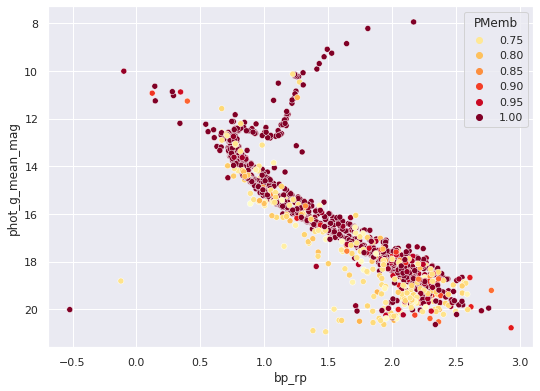

In [ ]:
# CMD of predicted members 

cmd = sns.scatterplot(x = 'bp_rp', y = 'phot_g_mean_mag', hue= 'PMemb', 
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.7] )
cmd.invert_yaxis()

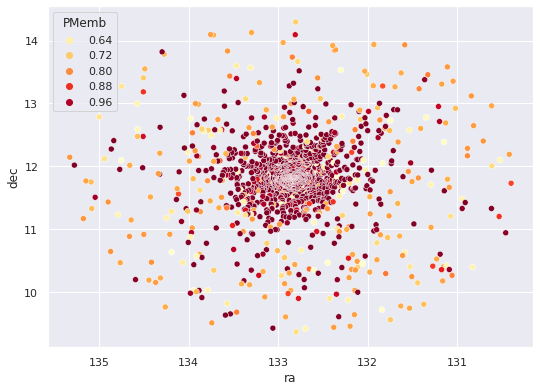

In [ ]:
skyplot = sns.scatterplot(x = 'ra', y = 'dec', hue= 'PMemb', 
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.6] )
skyplot.invert_xaxis()
plt.show()


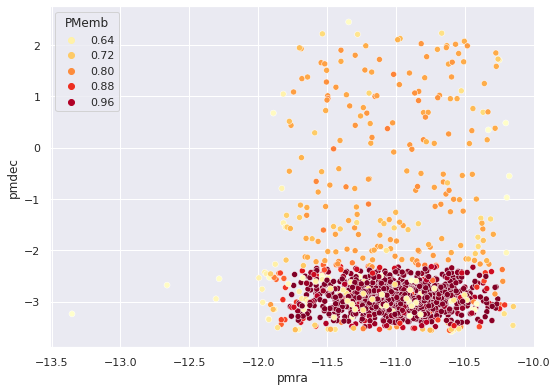

In [ ]:
# pm plot
sns.scatterplot(x = 'pmra', y = 'pmdec', hue= 'PMemb', 
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.6] )
plt.show()


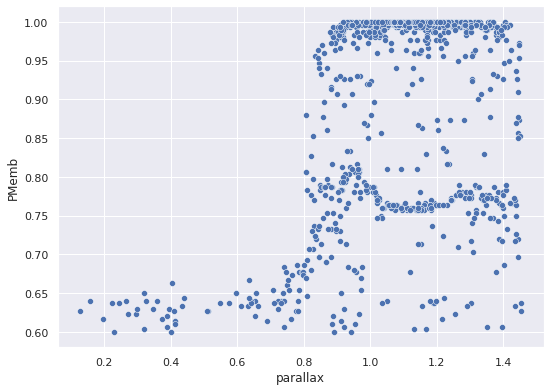

In [ ]:
# parallax plot
sns.scatterplot(x = 'parallax', y = 'PMemb',  
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.6] )

In [ ]:
# saving the files as csv
# all_stars.to_csv('gaia_6405_membership_prob.csv')

potentialMember.to_csv('M_67_membership_prob.csv')


### Comparing the old and new predicted members

In [ ]:
# creating subset for the potential member in previous dataset

concatenated = pd.concat([potentialMember.assign(dataset='New_member'), member.assign(dataset='Old_member')])


In [ ]:
concatenated.describe()

solution_id     source_id  ...  distance_pc  cluster
count  2.999000e+03  2.999000e+03  ...  1231.000000   1231.0
mean   1.635721e+18  6.040788e+17  ...   883.363798      0.0
std    0.000000e+00  2.427380e+15  ...    76.713059      0.0
min    1.635721e+18  5.972877e+17  ...   683.503523      0.0
25%    1.635721e+18  6.047578e+17  ...   842.426514      0.0
50%    1.635721e+18  6.049173e+17  ...   879.039050      0.0
75%    1.635721e+18  6.049631e+17  ...   915.839195      0.0
max    1.635721e+18  6.091473e+17  ...  1241.169903      0.0

[8 rows x 95 columns]

In [ ]:
member.describe()

solution_id     source_id  ...        PMemb  cluster
count  1.231000e+03  1.231000e+03  ...  1231.000000   1231.0
mean   1.635721e+18  6.042323e+17  ...     0.993525      0.0
std    0.000000e+00  2.102937e+15  ...     0.008692      0.0
min    1.635721e+18  5.986167e+17  ...     0.950331      0.0
25%    1.635721e+18  6.048986e+17  ...     0.993840      0.0
50%    1.635721e+18  6.049177e+17  ...     0.997116      0.0
75%    1.635721e+18  6.049603e+17  ...     0.997940      0.0
max    1.635721e+18  6.081313e+17  ...     0.998412      0.0

[8 rows x 94 columns]

In [ ]:
concatenated.dataset.value_counts()

New_member    1768
Old_member    1231
Name: dataset, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

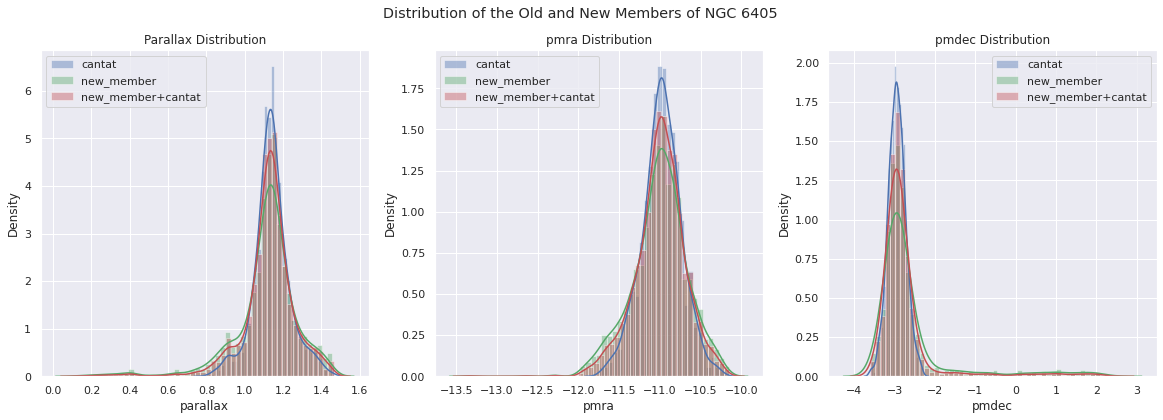

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Distribution of the Old and New Members of NGC 6405')


sns.distplot(member['parallax'], color = 'b', label = 'cantat', 
             kde=True, ax=axes[0])
sns.distplot(potentialMember['parallax'], color = 'g', label = 'new_member', 
             kde=True, ax=axes[0])
sns.distplot(concatenated['parallax'], color = 'r', ax=axes[0], kde=True,
             label = 'new_member+cantat')
axes[0].set_title('Parallax Distribution')
axes[0].legend()

sns.distplot(member['pmra'], color = 'b', label = 'cantat', 
             kde=True, ax=axes[1])
sns.distplot(potentialMember['pmra'], color = 'g', label = 'new_member', 
             kde=True, ax=axes[1])
sns.distplot(concatenated['pmra'], color = 'r', ax=axes[1], kde=True,
             label = 'new_member+cantat')
axes[1].set_title('pmra Distribution')
axes[1].legend()

sns.distplot(member['pmdec'], color = 'b', label = 'cantat', 
             kde=True, ax=axes[2])
sns.distplot(potentialMember['pmdec'], color = 'g', label = 'new_member', 
             kde=True, ax=axes[2])
sns.distplot(concatenated['pmdec'], color = 'r', ax=axes[2], kde=True,
             label = 'new_member+cantat')
axes[2].set_title('pmdec Distribution')
axes[2].legend()

plt.show()


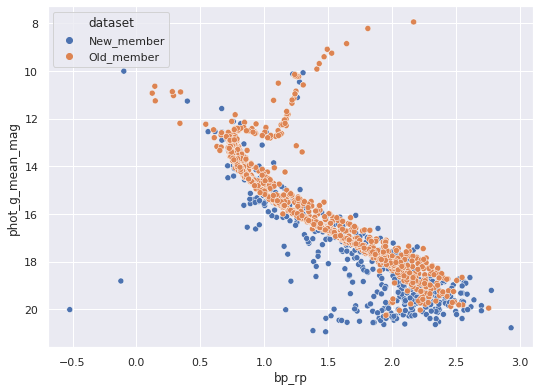

In [ ]:
cmd = sns.scatterplot(x='bp_rp', y='phot_g_mean_mag', data=concatenated,
                hue='dataset')
cmd.invert_yaxis()

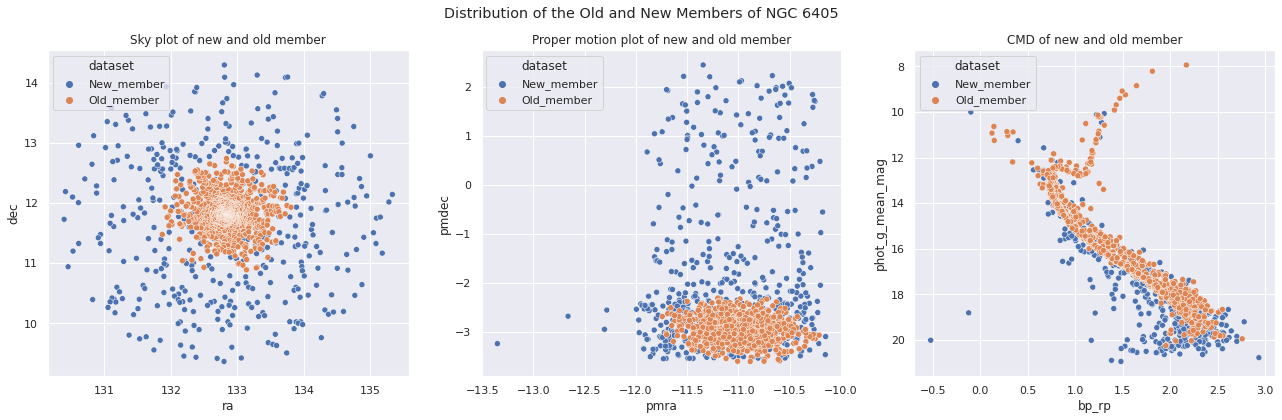

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(22,6))
fig.suptitle('Distribution of the Old and New Members of NGC 6405')

skyplot = sns.scatterplot(x='ra', y='dec', data=concatenated,
                hue='dataset', ax=axes[0])
axes[0].set_title('Sky plot of new and old member')

# proper motion plot
sns.scatterplot(x='pmra', y='pmdec', data=concatenated,
                hue='dataset', ax=axes[1])
axes[1].set_title('Proper motion plot of new and old member')

cmd = sns.scatterplot(x='bp_rp', y='phot_g_mean_mag', data=concatenated,
                hue='dataset', ax=axes[2])
cmd.invert_yaxis()
axes[2].set_title('CMD of new and old member')

plt.show()

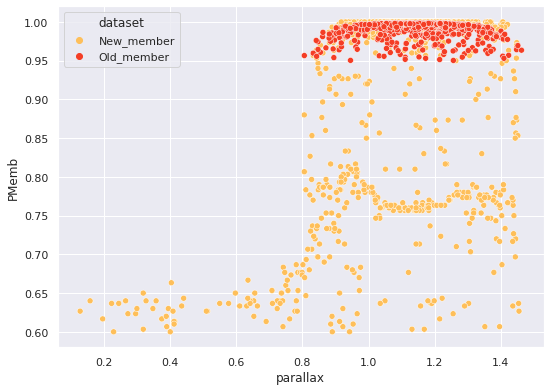

In [ ]:
# parallax vs PMemb plot
sns.scatterplot(x = 'parallax', y = 'PMemb',  hue = 'dataset',
                      palette='YlOrRd', data = concatenated )

In [ ]:
# pd_prof.ProfileReport(potentialMember)

In [ ]:
#files.download('M_67_cantat.csv')

#files.download('M_67_membership_prob.csv')

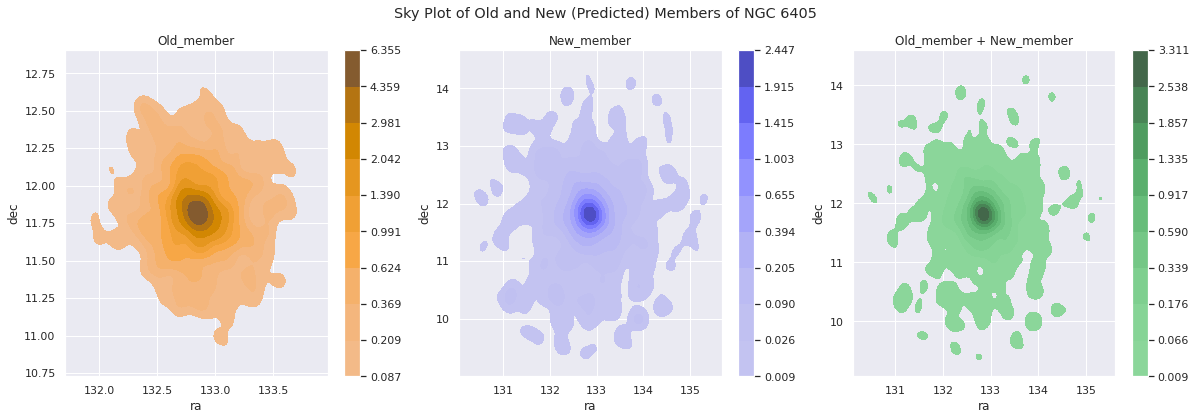

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Sky Plot of Old and New (Predicted) Members of NGC 6405')

sns.kdeplot(x='ra', y='dec', data = member, shade=True, color = 'orange', 
            bw_method = 0.20, cbar=True, ax=axes[0])
axes[0].set_title('Old_member')

sns.kdeplot(x='ra', y='dec', data = potentialMember, shade=True, color = 'blue', 
            bw_method = 0.20, cbar=True, ax=axes[1])
axes[1].set_title('New_member')

sns.kdeplot(x='ra', y='dec', data = concatenated, shade=True, color = 'g', 
            bw_method = 0.20, cbar=True, ax=axes[2])
axes[2].set_title('Old_member + New_member')

plt.show()

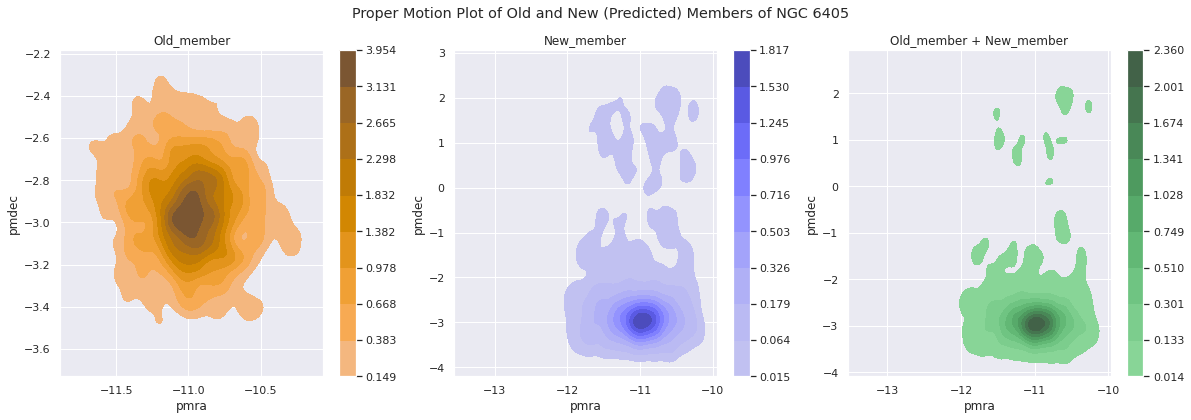

In [ ]:

fig, axes = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Proper Motion Plot of Old and New (Predicted) Members of NGC 6405')

sns.kdeplot(x='pmra', y='pmdec', data = member, shade=True, color = 'orange', 
            bw_method = 0.20, cbar=True, ax=axes[0])
axes[0].set_title('Old_member')

sns.kdeplot(x='pmra', y='pmdec', data = potentialMember, shade=True, color = 'blue', 
            bw_method = 0.20, cbar=True, ax=axes[1])
axes[1].set_title('New_member')

sns.kdeplot(x='pmra', y='pmdec', data = concatenated, shade=True, color = 'g', 
            bw_method = 0.20, cbar=True, ax=axes[2])
axes[2].set_title('Old_member + New_member')

plt.show()

In [ ]:
from google.colab import files

In [ ]:
#files.download('M_67_cantat.csv')

potentialMember.to_csv('M_67_additional_member_prob.csv')
concatenated.to_csv('M_67_all_member_prob.csv')

#files.download('M_67_all_member_prob.csv')
# column 'dataset': Old_member, New_member
# column 'member': 0 and 1
# column 'PMemb': decimal values between 0 to 1

files.download('M_67_additional_member_prob.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>